<a href="https://colab.research.google.com/github/hayatrajani/reinforcement-learning/blob/main/Tic_Tac_Toe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Modules

In [ ]:
import os
import pickle
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Design API

## Game
Creates a gaming framework for the player.

In [ ]:
class Game:
    def __init__(self):
        self.size = (3, 3)
        self.board = np.zeros(self.size)
        sb.set(font_scale=1.5)
        plt.ion()
        plt.show()

    def reset(self):
        self.board = np.zeros(self.size)
    
    # finds the available moves on the board where the value is 0 
    def availableMoves(self):
        return np.argwhere(self.board==0)
    
    def plotBoard(self):
        labels = np.where(self.board==0, '', self.board)
        labels = np.where(self.board==1, 'O', labels)
        labels = np.where(self.board==-1, 'X', labels)
        _ = sb.heatmap(self.board, vmin=-1, vmax=1, center=0, annot=labels, fmt='',
                      cmap='seismic', cbar=False, square=True, linecolor='black', linewidth=2)
        plt.pause(0.0001)
        plt.show()
    
    # check status of the board : returns True when there is win
    # inspects the abs(sum) along the rows, columns and diagnols
    # abs(sum) = 3 when all 'X' or all 'O'
    def checkStatus(self):
        sum_along_row = np.abs(np.sum(self.board, axis=0))
        sum_along_col = np.abs(np.sum(self.board, axis=1))
        sum_along_diag = abs(np.trace(self.board))
        sum_along_anti_diag = abs(np.trace(np.fliplr(self.board)))
        blen = len(self.board)
        if(np.any(sum_along_row == blen) or np.any(sum_along_col == blen) 
            or sum_along_diag == blen or sum_along_anti_diag == blen):
            return True
        return False

    def play(self, p1, p2, plot=True):
        p1.token, p2.token = -1, 1
        while True:
            if plot: self.plotBoard()
            # first player moves
            move = p1.nextMove(self.availableMoves(), self.board.copy())
            self.board[move] = p1.token
            # check if first player wins
            if self.checkStatus():
                result = p1.token
                break
            # check for draw if no available moves
            if len(self.availableMoves()) == 0:
                result = 0
                break
            if plot: self.plotBoard()
            # second player moves
            move = p2.nextMove(self.availableMoves(), self.board.copy())
            self.board[move] = p2.token
            # check if second player wins
            if self.checkStatus():
                result = p2.token
                break
            # check for draw if no available moves
            if len(self.availableMoves()) == 0:
                result = 0
                break
        p1.updateState(result)
        p2.updateState(result)
        if plot: self.plotBoard()
        self.reset()
        return result

## Player
Simulates a player with three possible modes:
* **manual**: asks the player to manually select the next move
* **automated**: places a piece such that the state value is maximized, making random moves occasionaly
* **random**: places a piece uniformly among empty fields



In [ ]:
class Player:
    def __init__(self, playerType):
        self.type = playerType
        self.token = None
        self.states = []
        self.stateValue = {}
    
    # Task 1.2
    def encodeState(self, board):
        # Reshape the 3x3 board as a 1x9 array, convert it to a string
        # and chop off the enclosing brackets for nicety
        # to get a unique representation for each state of the board
        return np.array2string(board.reshape(board.size))[1:-1]
    
    def updateState(self, status):
        if self.type != 'random':
            # V(final_state) = 1 if win else 0
            self.stateValue[self.states[-1]] = 1 if status == self.token else 0
            # Update V(s) for all visited states in reverse order
            for i in range(len(self.states)-2, -1, -1):
                vs = self.stateValue.get(self.states[i], 0.1)       # current state
                vs_ = self.stateValue[self.states[i+1]]             # successor state
                self.stateValue[self.states[i]] = vs+0.2*(vs_-vs)   # update current state
            self.states = []                                        # reset state list for next game
    
    def savePolicy(self, path, verbose=True):
        head = os.path.split(path)[0]
        if head:
            if not os.path.exists(head):
                os.makedirs(head)
        with open(path, 'wb') as f:
            pickle.dump(self.stateValue, f)
        if verbose: print('Policy saved to',path)
    
    def loadPolicy(self, path, verbose=True):
        if not os.path.isfile(path):
            print('Invalid path! File does not exist')
            return
        with open(path, 'rb') as f:
            self.stateValue = pickle.load(f)
        if verbose: print('Policy loaded from',path)
    
    def nextMove(self, availableMoves, board):
        # human plays manually
        if self.type == 'manual':
            while True:
                move = input('Next Move <row,col>: ')
                move = [int(i) for i in move.split(',')]
                if move in availableMoves.tolist():
                    move = tuple(move)
                    board[move] = self.token
                    self.states.append(self.encodeState(board))
                    return move
                else:
                    print('Invalid move, try again!')   
        # places a piece such that the state value is maximized, making random moves occasionaly
        elif self.type == 'automated':
            # with probability 0.1 place piece uniformly among empty fields
            if np.random.random() < 0.1:
                move = tuple(availableMoves[np.random.choice(len(availableMoves))])
            # with probability 0.9 place piece such that V(s) is maximized
            else:
                maxx = -np.inf
                movelist = []
                for m in availableMoves:
                    m = tuple(m)
                    temp = board[m]             # copy old state
                    board[m] = self.token       # try a potential next state
                    vs = self.stateValue.get(self.encodeState(board),0.1)
                    if vs > maxx:               # if better chance of winning
                        maxx = vs
                        movelist = [m]          # set as next move
                    elif vs == maxx:
                        movelist.append(m)
                    board[m] = temp             # else restore old state and repeat
                # randomly break ties between move of same value
                move = movelist[np.random.choice(len(movelist))]
            board[move] = self.token
            self.states.append(self.encodeState(board))
            return move
        # place a piece uniformly among empty fields
        elif self.type == 'random':
            return tuple(availableMoves[np.random.choice(len(availableMoves))])
        # if your're too lazy to play manually
        elif self.type == 'random_learn':
            move = tuple(availableMoves[np.random.choice(len(availableMoves))])
            board[move] = self.token
            self.states.append(self.encodeState(board))
            return move
        else:
            raise NotImplementedError

# Run Tests

## Initialize game and Define helper functions

In [ ]:
%matplotlib inline

# helper function to print the values for initial state of all possible nine moves
def showInitialValueState(p, boardlen=3):
    board = np.zeros((boardlen, boardlen))
    # value state for all the possible initial moves
    vs_init = np.zeros((3,3))
    for k in range(board.size):
        i, j = k//boardlen, k%boardlen
        board[i,j] = p.token
        vs_init[i,j] = p.stateValue.get(p.encodeState(board),0.1)
        board[i,j] = 0
    return vs_init

game = Game()

## Task 1.1
One run of the game

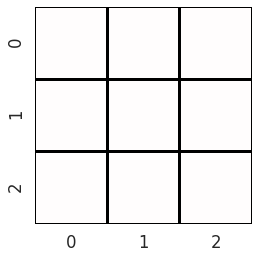

Next Move <row,col>: 0,0


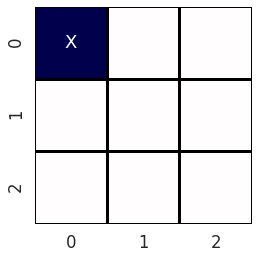

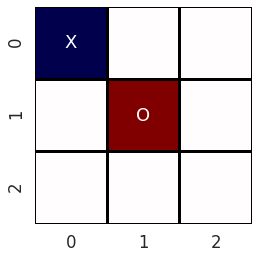

Next Move <row,col>: 1,0


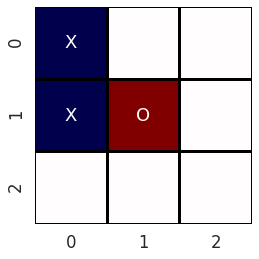

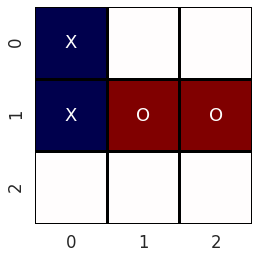

Next Move <row,col>: 2,0


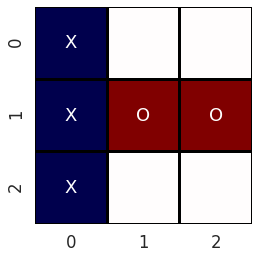

Player 1 wins!



In [ ]:
p1 = Player('manual')
p2 = Player('random')

winner = game.play(p1, p2)
if winner == -1: print('Player 1 wins!\n')
elif winner == 1: print('Player 2 wins!\n')
elif winner == 0: print('Match Draw!\n')


## Task 1.2
Encoding of the game state 's' for storing the value V(s). 
- Game board encoded using 'encodeState' function in 'Player' class.
- V(s) stored as dict in 'stateValue' variable of 'Player' class with encoded state 's' as key and the value V(s).  

## Task 1.3
Play 10 games and set V(s)=1 when there is a win and V(s)=0 when there is a loss or the game ends in a draw, i.e. no further pieces can be placed. At the end of each game, go through all states that you visited in reverse order and set V(s) = V(s) + 0.2(V(s’) - V(s)), where s’ is the successor state.

Game  1


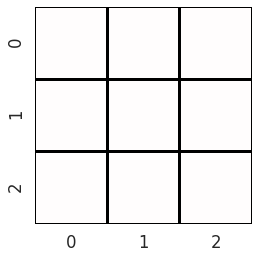

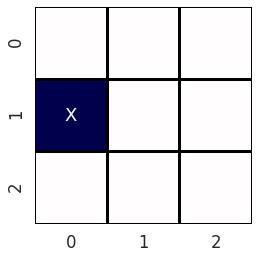

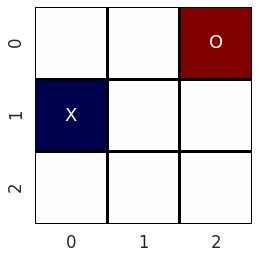

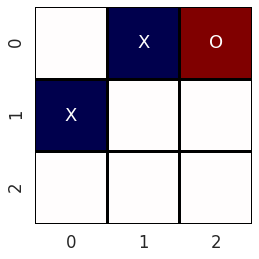

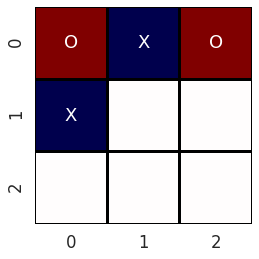

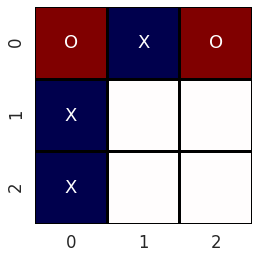

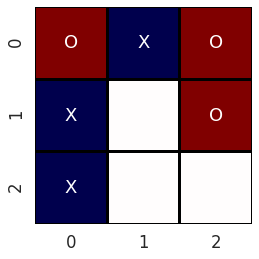

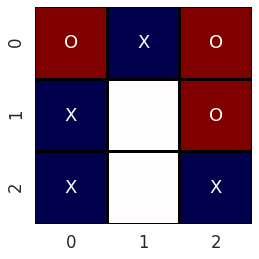

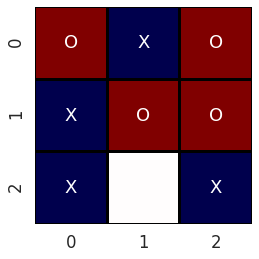

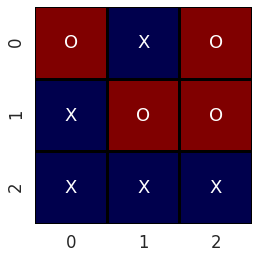

Player 1 wins!

Game  2


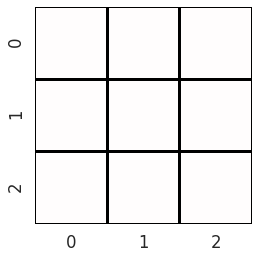

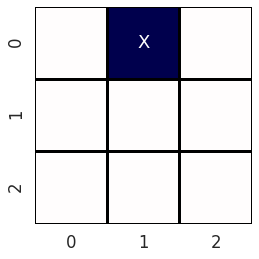

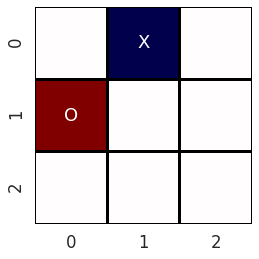

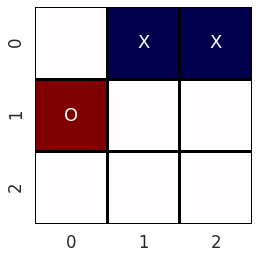

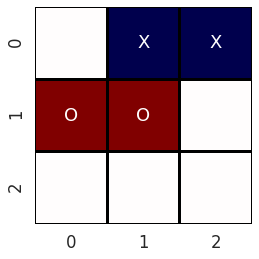

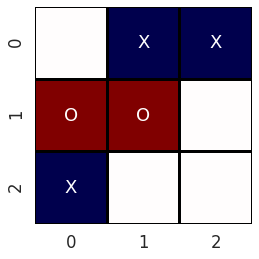

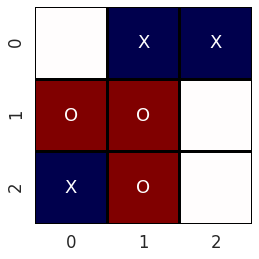

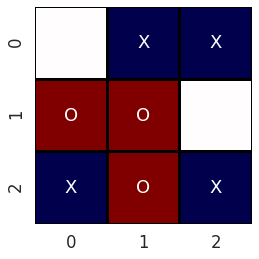

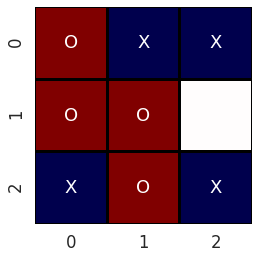

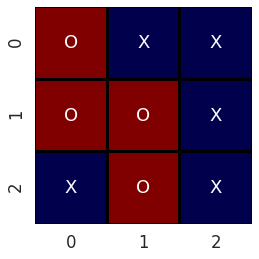

Player 1 wins!

Game  3


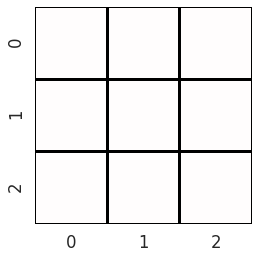

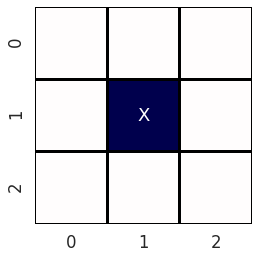

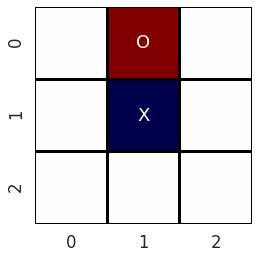

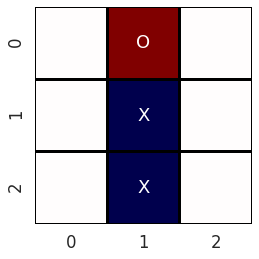

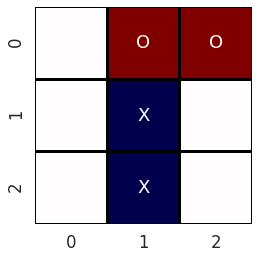

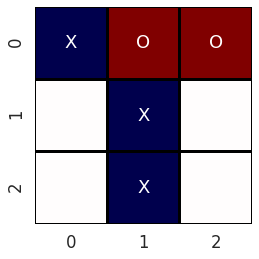

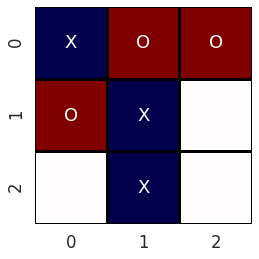

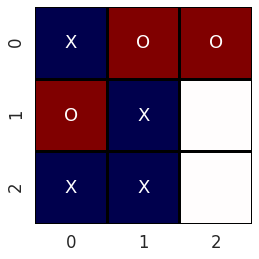

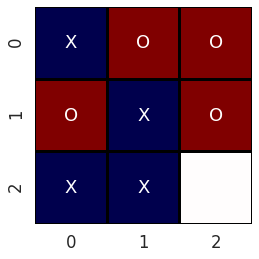

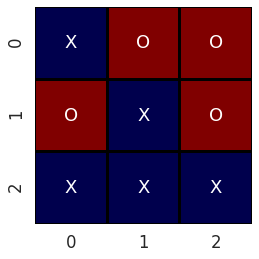

Player 1 wins!

Game  4


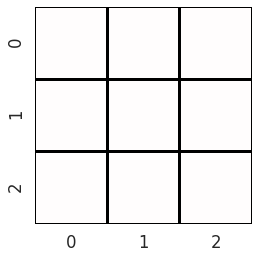

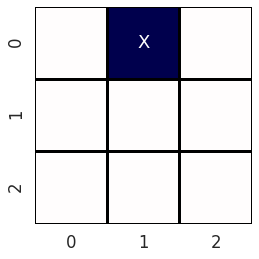

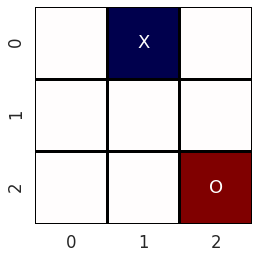

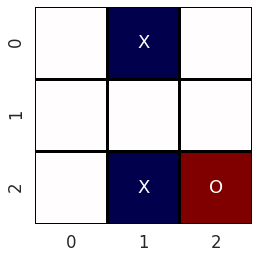

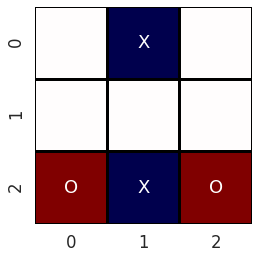

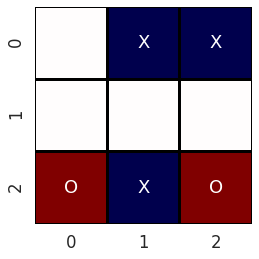

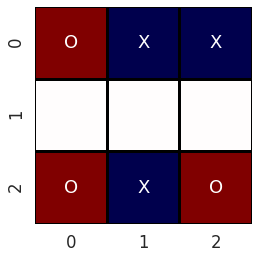

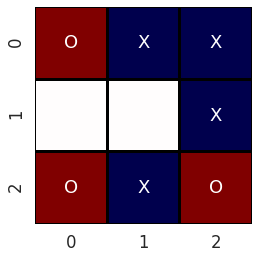

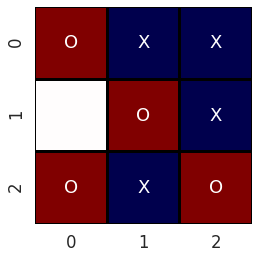

Player 2 wins!

Game  5


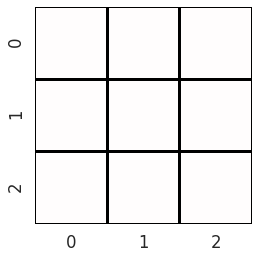

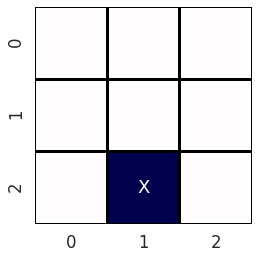

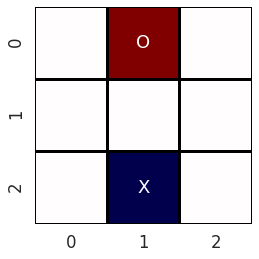

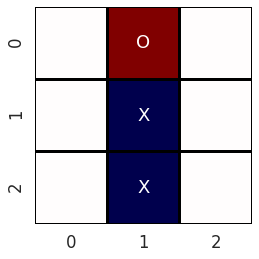

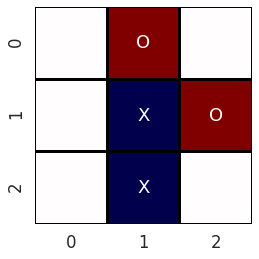

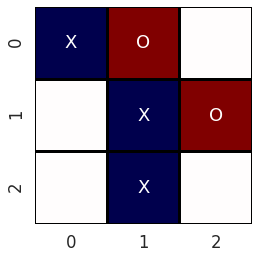

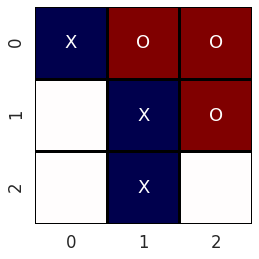

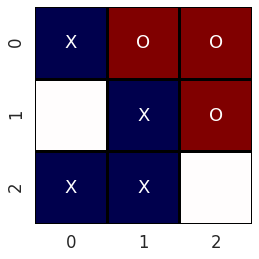

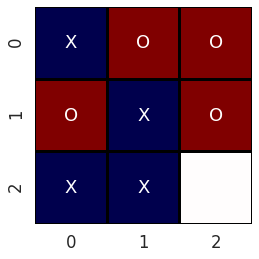

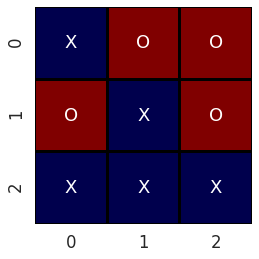

Player 1 wins!

Game  6


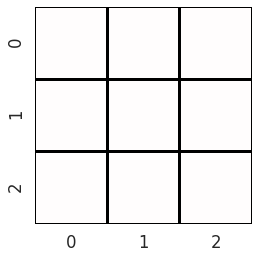

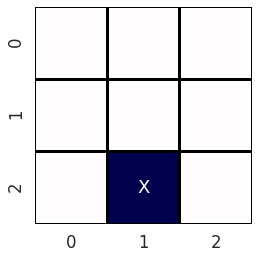

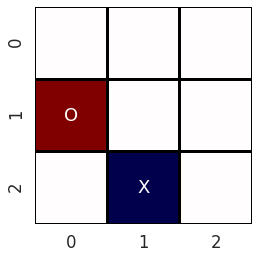

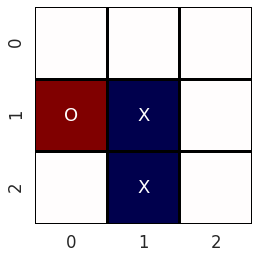

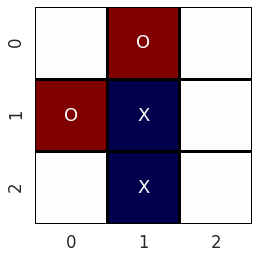

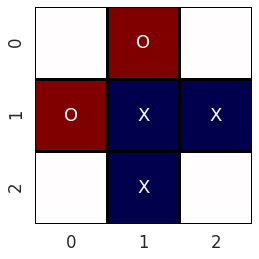

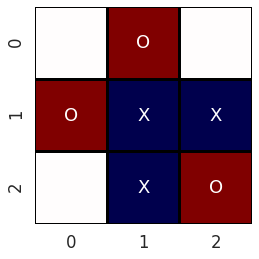

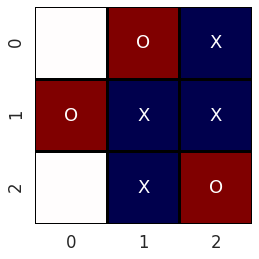

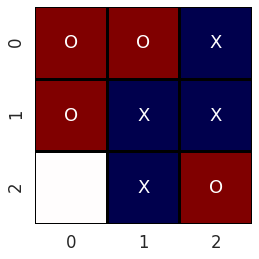

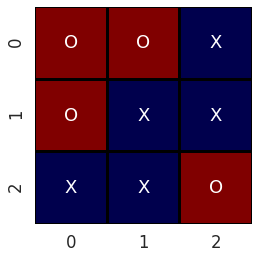

Player 1 wins!

Game  7


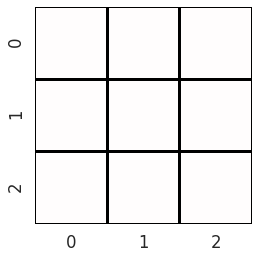

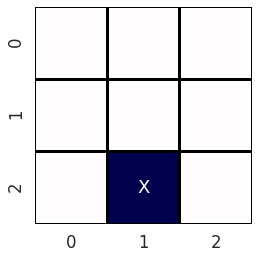

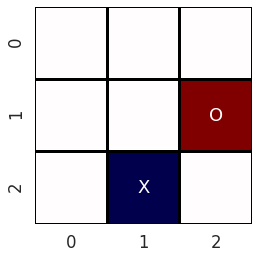

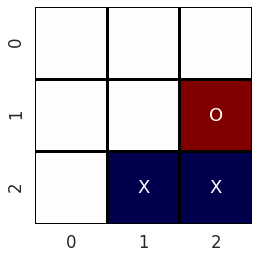

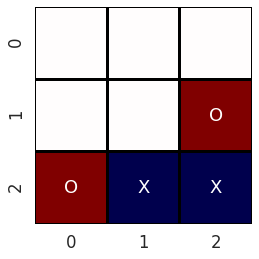

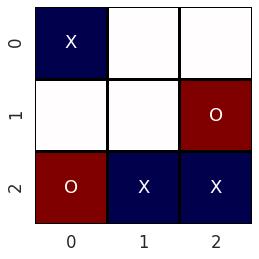

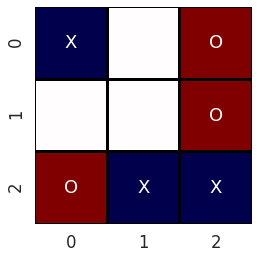

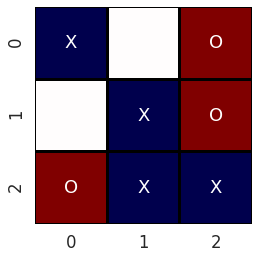

Player 1 wins!

Game  8


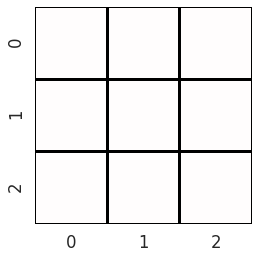

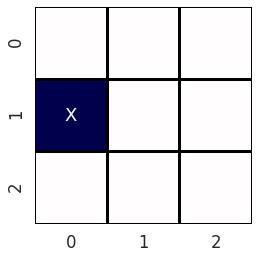

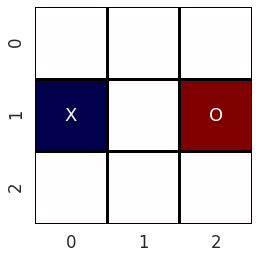

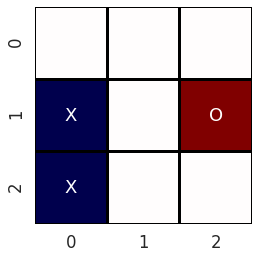

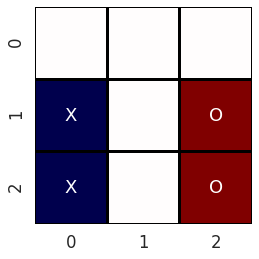

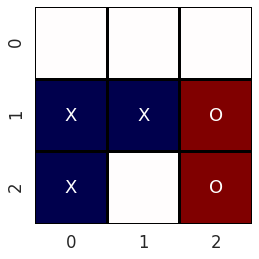

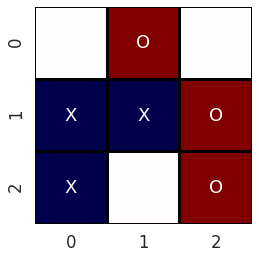

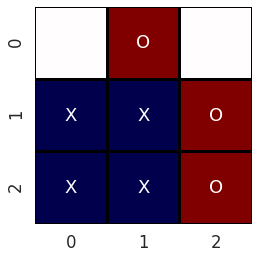

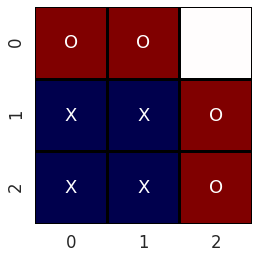

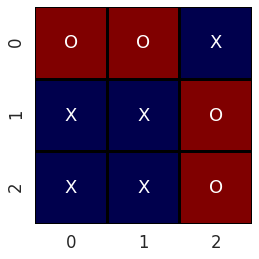

Player 1 wins!

Game  9


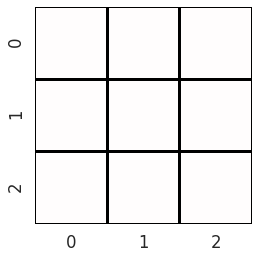

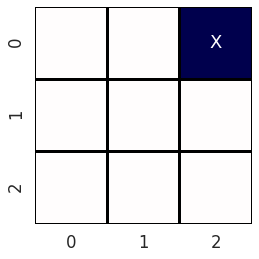

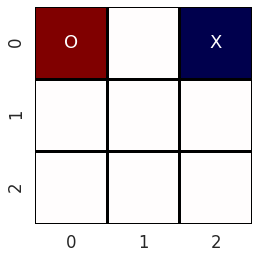

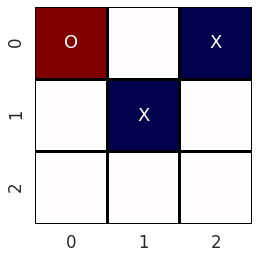

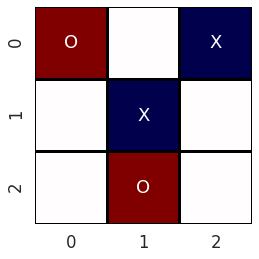

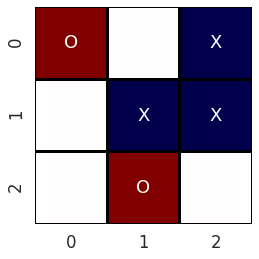

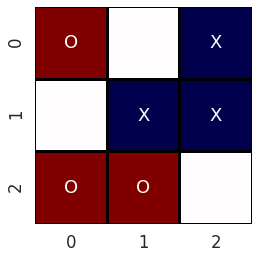

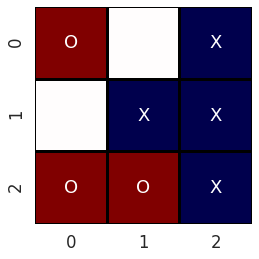

Player 1 wins!

Game  10


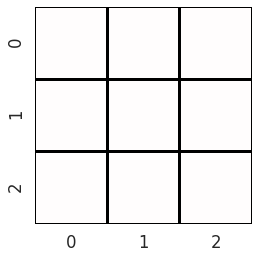

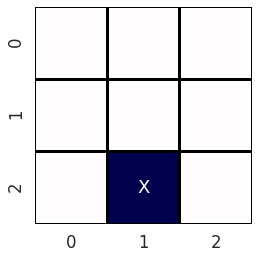

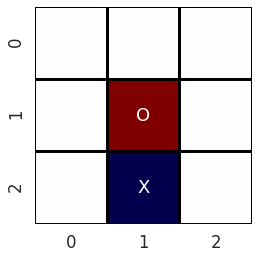

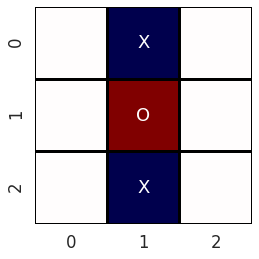

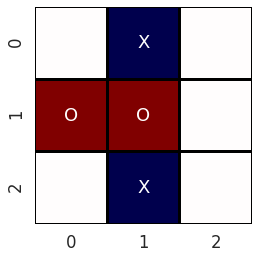

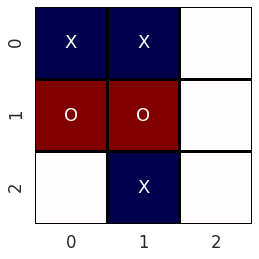

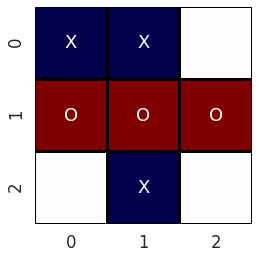

Player 2 wins!

Policy saved to policy_1-3.dat


In [ ]:
# game begins
# set p1 = PLayer('random_learn') to avoid playing maually
p1 = Player('manual')
p2 = Player('random')
for i in range(10):
    print('Game ',i+1)
    winner = game.play(p1, p2)
    if winner == -1: print('Player 1 wins!\n')
    elif winner == 1: print('Player 2 wins!\n')
    elif winner == 0: print('Match Draw!\n')
p1.savePolicy('policy_1-3.dat')

### "Learned" state values for all possible 9 initial moves

V(s) for all 9 states where you can place your first move:
[[0.1       0.100352  0.1072   ]
 [0.102592  0.10144   0.1      ]
 [0.1       0.1040087 0.1      ]]


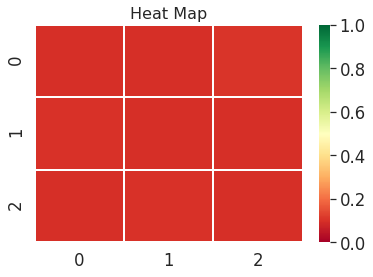

In [ ]:
vs_init = showInitialValueState(p1)
print('V(s) for all 9 states where you can place your first move:',vs_init,sep='\n')
fig = sb.heatmap(vs_init, vmin=0, vmax=1, cmap='RdYlGn', linecolor='white', linewidths=1)
_ = fig.set_title('Heat Map',{'fontsize':16})

## Task 1.4
Replace your placement selection by an automated procedure that with probability 0.9 places your piece such that V(s) is maximized (break ties randomly) and with probability 0.1 places your piece uniformly among the empty fields.

Play 1000 automated games. For every 100 games compute how often your player won and document this learning curve!

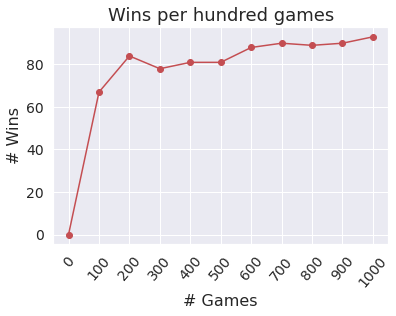

In [ ]:
p1 = Player('automated')
# initialize state values with results from task 1.3
p1.loadPolicy('policy_1-3.dat', verbose = False)
p2 = Player('random')

wincount = 0
win_per_hundred = [0]
for i in range(1000):
    winner = game.play(p1, p2, plot=False)
    if(winner == -1):
        wincount += 1
    if((i+1)%100==0):
        win_per_hundred.append(wincount)
        wincount = 0

_ = plt.rc('figure', titlesize=18)
_ = plt.rc('axes', labelsize=16)
_ = plt.rc('xtick', labelsize=14)
_ = plt.rc('ytick', labelsize=14)

plt.plot(win_per_hundred,'-or')
plt.title('Wins per hundred games')
plt.ylabel('# Wins')
plt.xlabel('# Games')
plt.xticks(range(len(win_per_hundred)),[i*100 for i in range(len(win_per_hundred))], rotation=50)

p1.savePolicy('policy_1-4.dat', verbose = False)
#files.download('policy_1-4.dat')

### "Learned" state values for all possible 9 initial moves

V(s) for all 9 states where you can place your first move:
[[0.23717094 0.46704927 0.80729758]
 [0.20344091 0.33380059 0.35262932]
 [0.18199103 0.24314317 0.39164756]]


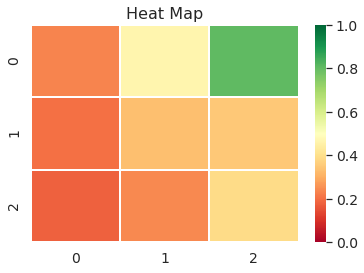

In [ ]:
vs_init = showInitialValueState(p1)
print('V(s) for all 9 states where you can place your first move:',vs_init,sep='\n')
fig = sb.heatmap(vs_init, vmin=0, vmax=1, cmap='RdYlGn', linecolor='white', linewidths=1)
_ = fig.set_title('Heat Map',{'fontsize':16})